# What is about ?

# Scanpy tutorial notebook "Preprocessing and clustering 3k PBMCs" - adaptation for kaggle

This tutorial from 2017, demonstrates that scanpy can do basically the same as R-package "Seurat" - guided clustering tutorial (Satija et al., 2015).


The data consist of 3k PBMCs from a Healthy Donor and are freely available from 10x Genomics (here from this webpage).

PMBC - A peripheral blood mononuclear cell (PBMC) is any peripheral blood cell having a round nucleus.These cells consist of lymphocytes (T cells, B cells, NK cells) and monocytes, whereas erythrocytes and platelets have no nuclei, and granulocytes (neutrophils, basophils, and eosinophils) have multi-lobed nuclei. In humans, lymphocytes make up the majority of the PBMC population, followed by monocytes, and only a small percentage of dendritic cells.
https://en.wikipedia.org/wiki/Peripheral_blood_mononuclear_cell

We preliminary downloaded data into kaggle dataset, so one can work with data in usual kaggle way.





More on data.

Alrernatively - on a unix system, you can uncomment and run the following to download and unpack the data. The last line creates a directory for writing processed data.

    # !mkdir data
    # !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
    # !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
    # !mkdir write


In [59]:
!mkdir data
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
!mkdir write

mkdir: cannot create directory ‘data’: File exists
--2024-12-30 17:21:30--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.1.173, 104.18.0.173, 2606:4700::6812:ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [following]
--2024-12-30 17:21:31--  https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7,3M) [application/x-tar]
Saving to: ‘data/pbmc3k_filtered_gene_bc_matrices.tar.gz’

data/pbmc3k_filtere 100%[===================>]   7,27M  2,76MB/s    in 2,6s    

2024-12-30 17:21:34

In [60]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Install/import modules

In [61]:
import scanpy as sc

import numpy as np
import pandas as pd
import scipy 

import os
import sys
import time
t0start = time.time()


import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 70
#plt.style.use('dark_background')
import seaborn as sns

from sklearn.decomposition import PCA

In [62]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.10.4 anndata==0.11.1 umap==0.5.7 numpy==2.0.2 scipy==1.14.1 pandas==2.2.3 scikit-learn==1.6.0 statsmodels==0.14.4 igraph==0.11.8 pynndescent==0.5.13


In [63]:
results_file = 'pbmc3k.h5ad'# ''write/pbmc3k.h5ad'  # the file that will store the analysis results

In [64]:
path_and_filename = '/home/user/BioinformaticTutorials/workshop4/data/filtered_gene_bc_matrices/hg19'
adata = sc.read_10x_mtx(
    path_and_filename, # 'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)  

adata

... reading from cache file cache/home-user-BioinformaticTutorials-workshop4-data-filtered_gene_bc_matrices-hg19-matrix.h5ad


AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [65]:
adata.var.head()
    # Index of dataframe adata.var - standard symbols for genes
    # The only column - gene_ids - contains Ensembl gene Ids - https://www.ensembl.org/info/genome/stable_ids/index.html
    # One can easily recongnize them: ENSG00000NUMBER - gene ids, for humans, ENSMUSG00000Number - for mouse etc...
    # It is quite standard system of Ids for genes togather with Entrez

,gene_ids
MIR1302-10,ENSG00000243485
FAM138A,ENSG00000237613
OR4F5,ENSG00000186092
RP11-34P13.7,ENSG00000238009
RP11-34P13.8,ENSG00000239945


In [66]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`


In [58]:
adata.obs.head()

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden
AAACATACAACCAC-1,781,779,2419.0,73.0,3.017776,0
AAACATTGAGCTAC-1,1352,1352,4903.0,186.0,3.793596,2
AAACATTGATCAGC-1,1131,1129,3147.0,28.0,0.889736,0
AAACCGTGCTTCCG-1,960,960,2639.0,46.0,1.743085,5
AAACCGTGTATGCG-1,522,521,980.0,12.0,1.224490,4


TypeError: 'module' object is not callable

# Preprocessing

Show those genes that yield the highest fraction of counts in each single cell, across all cells.

normalizing counts per cell
    finished (0:00:00)


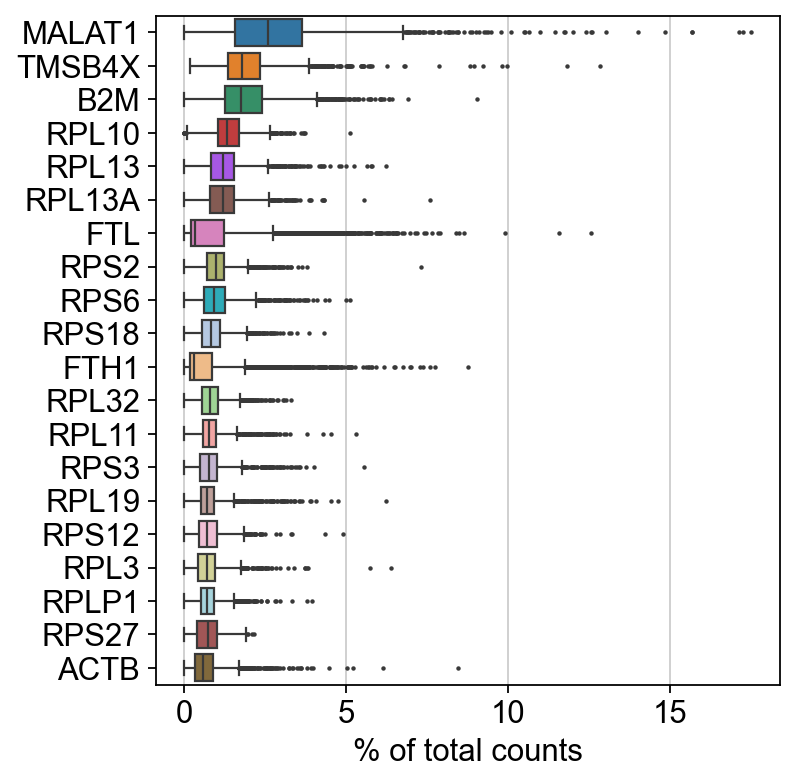

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [9]:
sc.pl.highest_expr_genes(adata, n_top=20, )
adata

Basic filtering:

In [10]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
# Added columns: 
    #'n_genes' - how many genes are expressed in that cell 
    #'n_cells' - for how many cells particular gene is expressed 
    
adata

filtered out 19024 genes that are detected in less than 3 cells


AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

Let’s assemble some information about mitochondrial genes, which are important for quality control.

Citing from “Simple Single Cell” workflows (Lun, McCarthy & Marioni, 2017):

High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.
With pp.calculate_qc_metrics, we can compute many metrics very efficiently.

In [11]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# Added columns: 
    # for obs - 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    # for var -  'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
adata

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

A violin plot of some of the computed quality measures:

the number of genes expressed in the count matrix
the total counts per cell
the percentage of counts in mitochondrial genes

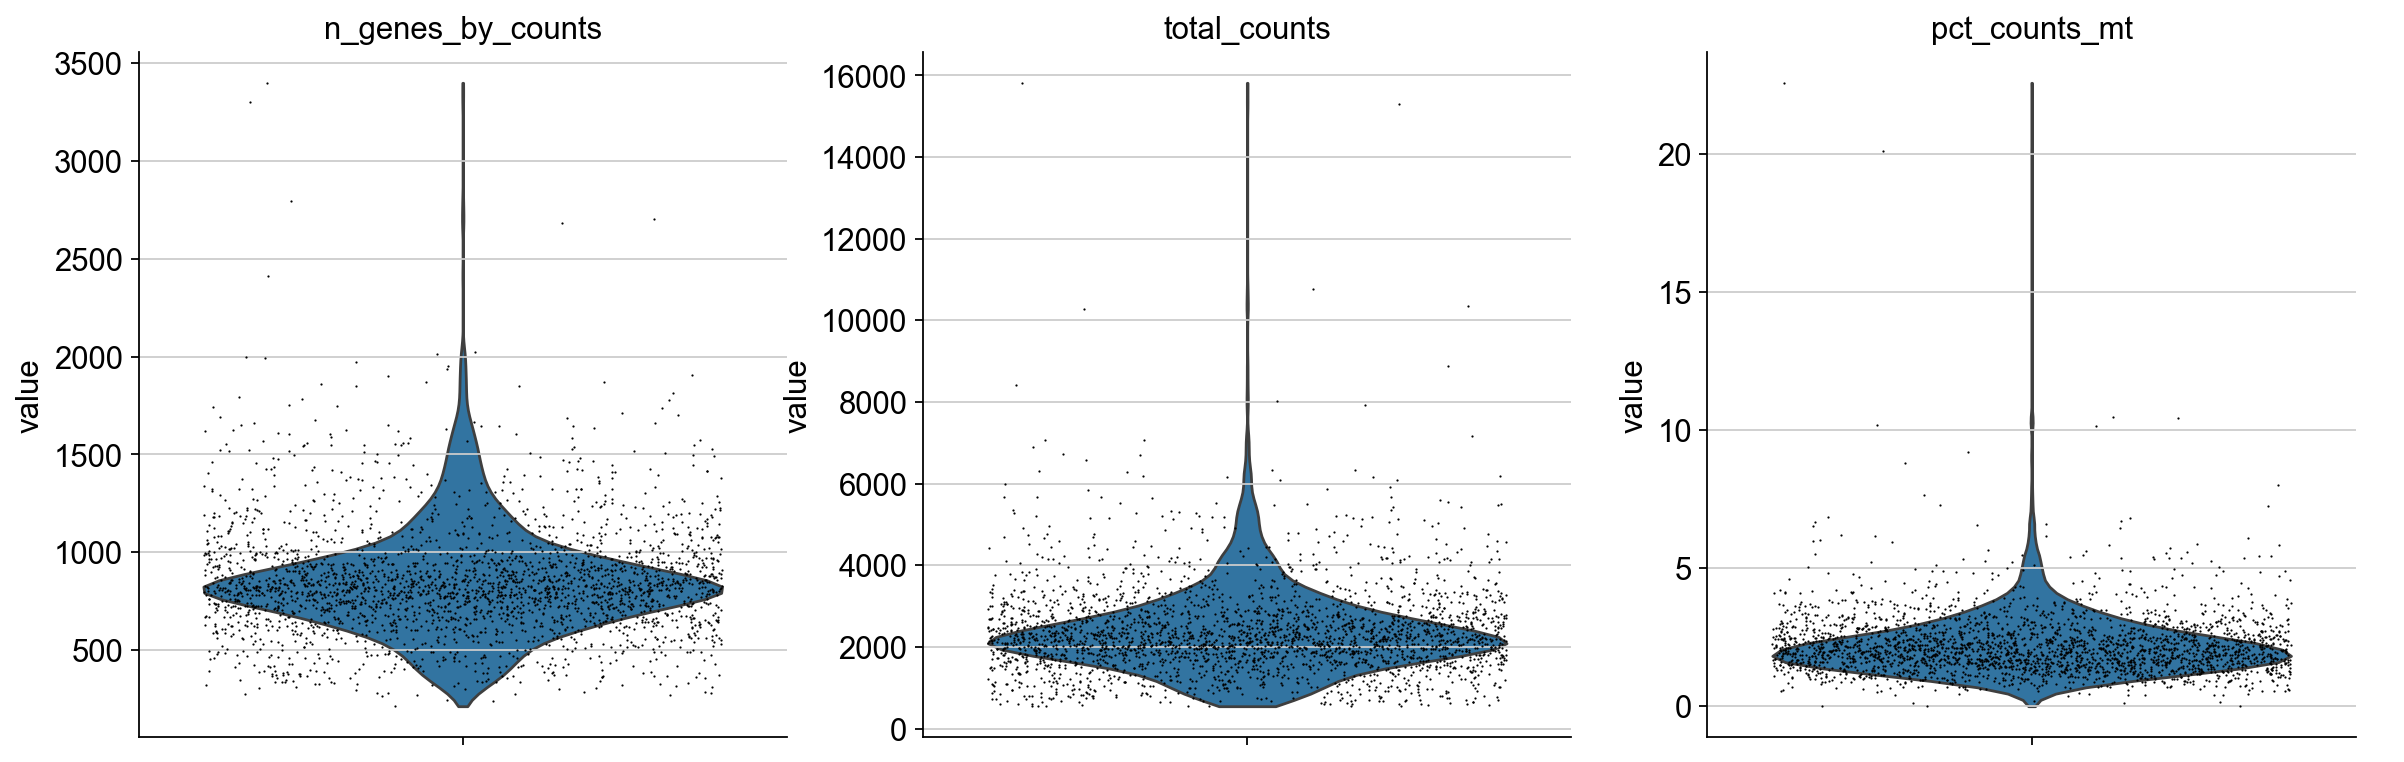

In [12]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

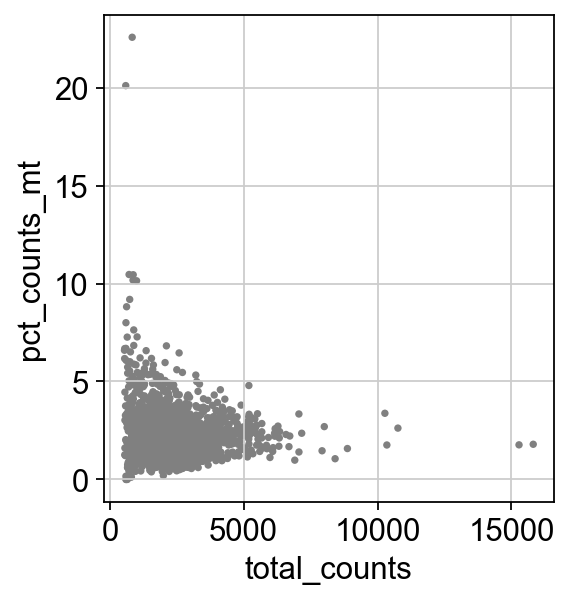

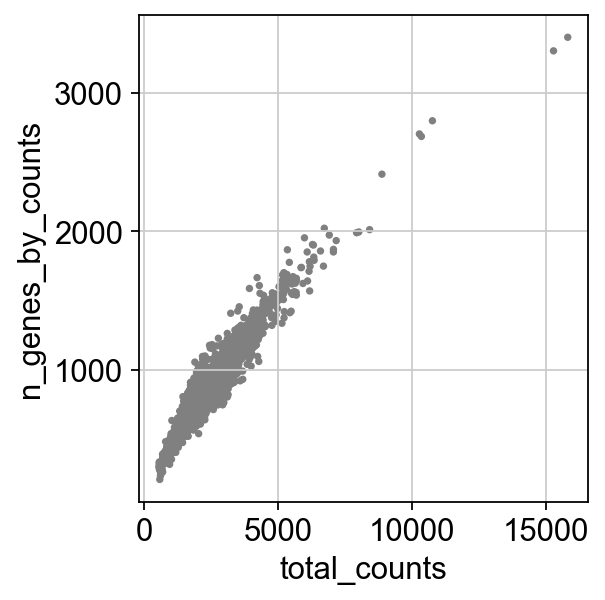

In [13]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [14]:
adata

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [15]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
adata

View of AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

Total-count normalize (library-size correct) the data matrix X to 10,000 reads per cell, so that counts become comparable among cells.

In [16]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/home/user/BioinformaticTutorials/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Logarithmize the data:

In [19]:
sc.pp.log1p(adata)

Identify highly-variable genes.

In [20]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [21]:
adata.var[ [ 'highly_variable', 'means', 'dispersions', 'dispersions_norm' ]].head()

,highly_variable,means,dispersions,dispersions_norm
AL627309.1,False,0.013556,1.432845,-0.624328
AP006222.2,False,0.004696,1.458631,-0.573416
RP11-206L10.2,False,0.005673,1.325459,-0.836359
RP11-206L10.9,False,0.002644,0.859264,-1.756848
LINC00115,False,0.027437,1.457477,-0.575693


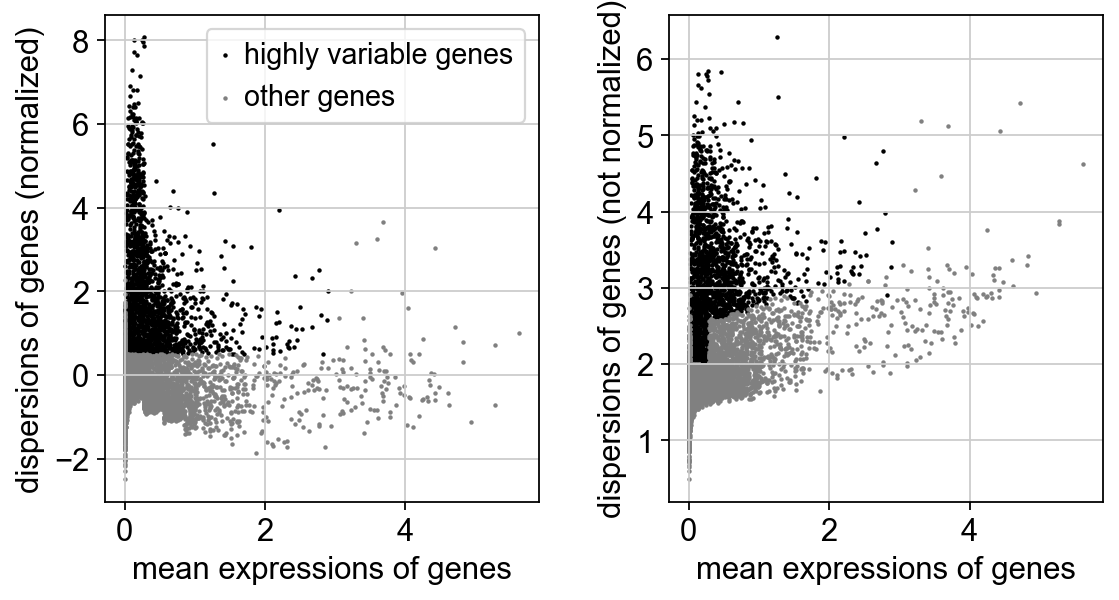

In [22]:
sc.pl.highly_variable_genes(adata)

Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.


You can get back an AnnData of the object in .raw by calling .raw.to_adata().

In [23]:
adata.raw = adata

If you don’t proceed below with correcting the data with sc.pp.regress_out and scaling it via sc.pp.scale, you can also get away without using .raw at all.

The result of the previous highly-variable-genes detection is stored as an annotation in .var.highly_variable and auto-detected by PCA and hence, sc.pp.neighbors and subsequent manifold/graph tools. In that case, the step actually do the filtering below is unnecessary, too.

In [24]:
# Actually do the filtering
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [25]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use


/home/user/BioinformaticTutorials/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:672: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:02)


Scale each gene to unit variance. Clip values exceeding standard deviation 10.

In [26]:
sc.pp.scale(adata, max_value=10)

# Principal component analysis

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.


In [27]:
sc.tl.pca(adata, svd_solver='arpack')

# Adds: adata.obsm.X_pca, adata.varm.PCs

computing PCA
    with n_comps=50
    finished (0:00:01)


In [28]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

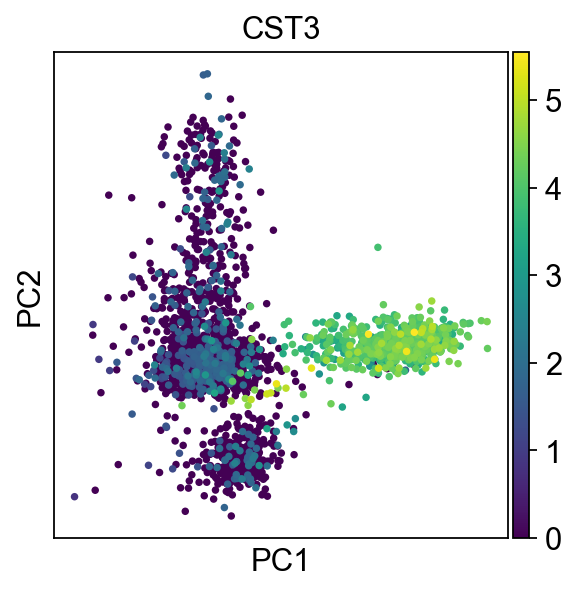

In [29]:
sc.pl.pca(adata, color='CST3')

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function sc.tl.louvain() or tSNE sc.tl.tsne(). In our experience, often a rough estimate of the number of PCs does fine.

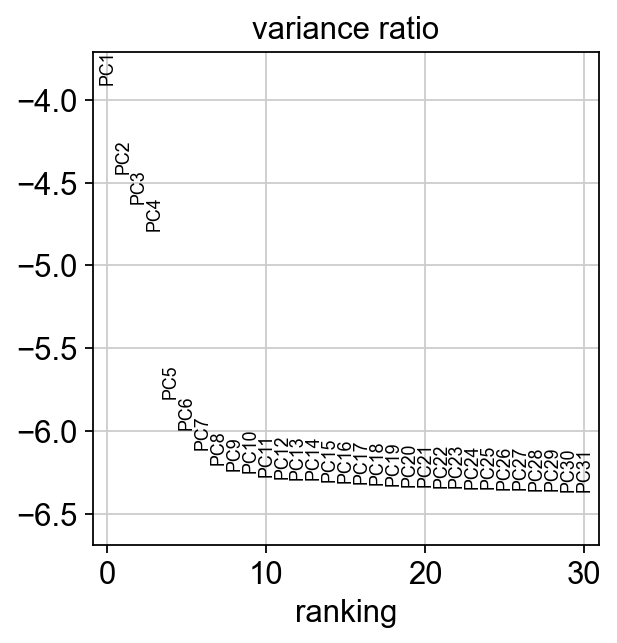

In [30]:
sc.pl.pca_variance_ratio(adata, log=True)

In [31]:
# Save the result.
adata.write(results_file)

In [32]:
adata


AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

# Computing the neighborhood graph
Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat’s results, let’s take the following values.

In [33]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


# Embedding the neighborhood graph
We suggest embedding the graph in two dimensions using UMAP (McInnes et al., 2018), see below. It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preserves trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

In [34]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:02)


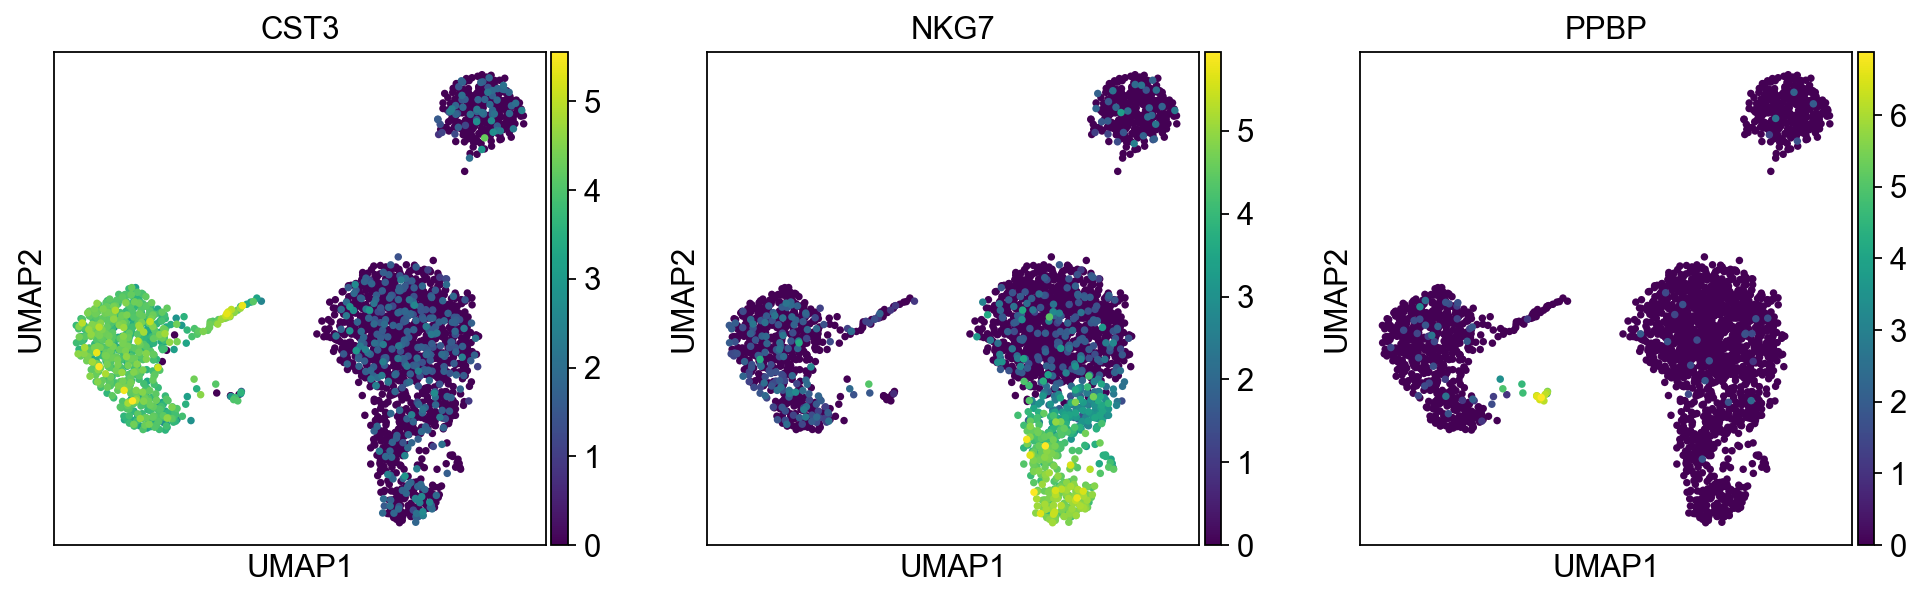

In [35]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

As we set the .raw attribute of adata, the previous plots showed the “raw” (normalized, logarithmized, but uncorrected) gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don’t want to use .raw.

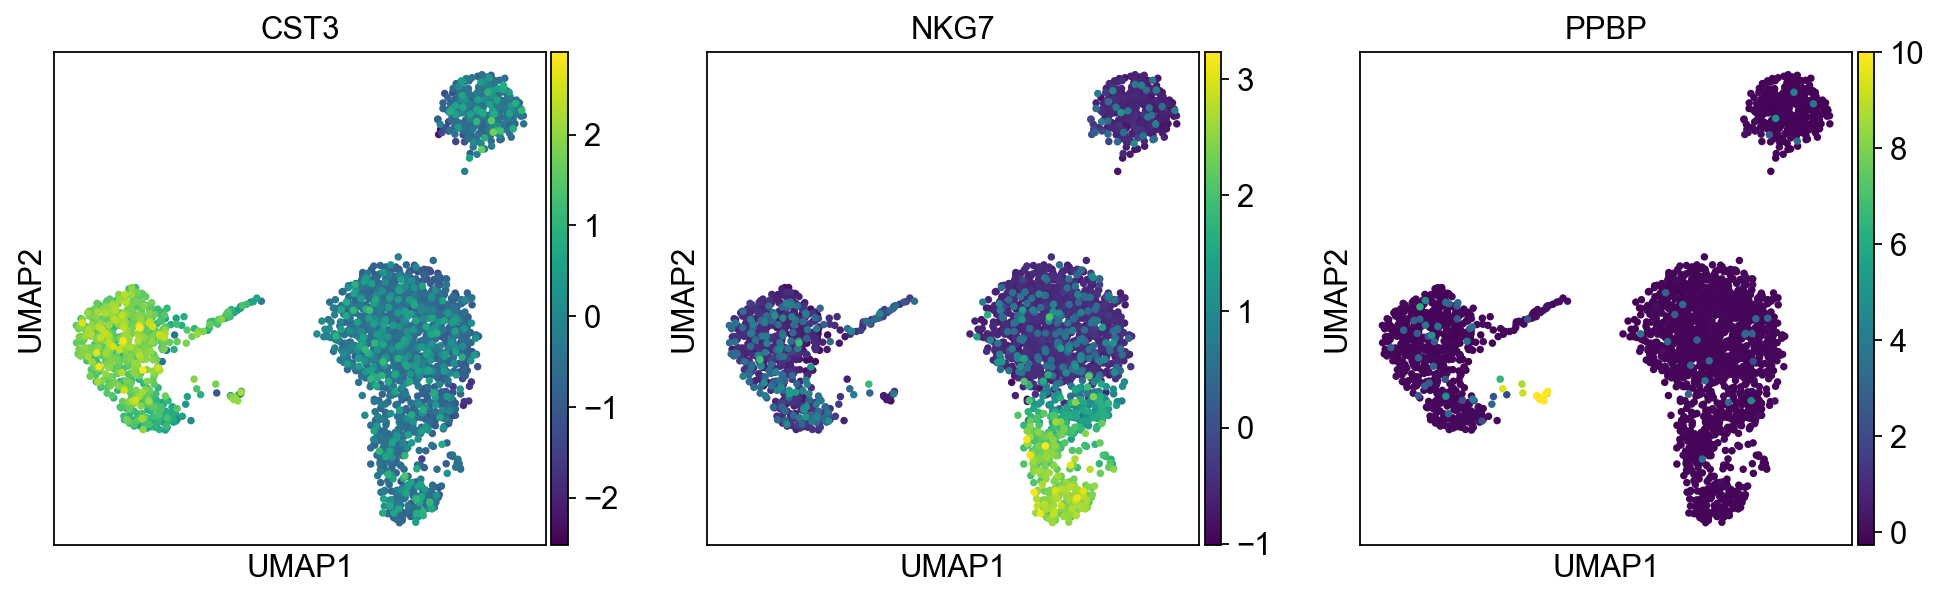

In [36]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

# Clustering the neighborhood graph
As with Seurat and many other frameworks, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by Traag *et al.* (2018). Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [37]:
!pip install leidenalg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 4.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 4.8 MB/s eta 0:00:00a 0:00:01


In [38]:
sc.tl.leiden(adata)

running Leiden clustering


/tmp/ipykernel_14117/3467744858.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


Plot the clusters, which agree quite well with the result of Seurat.

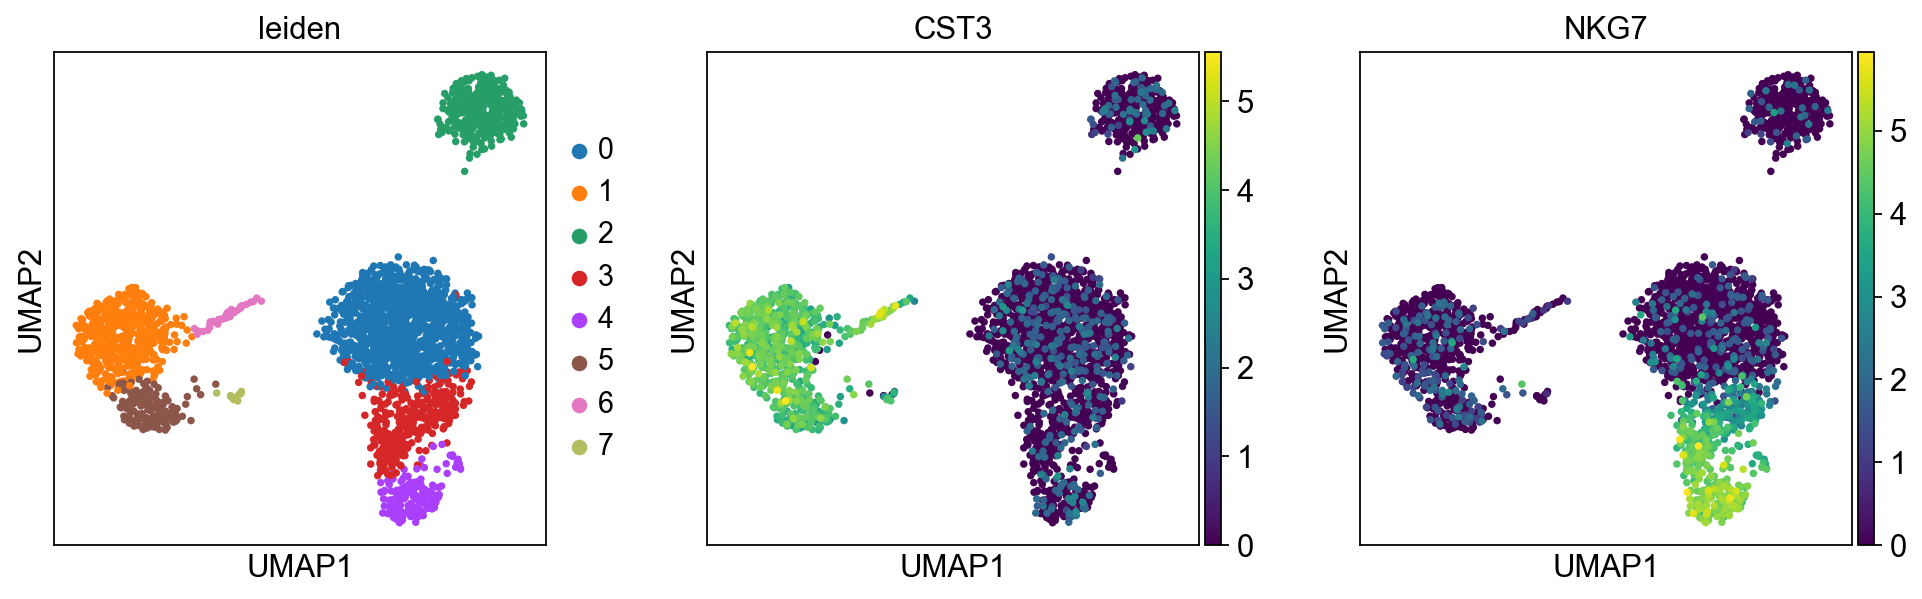

In [39]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

In [40]:
adata.write(results_file)


# Finding marker genes
Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the .raw attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


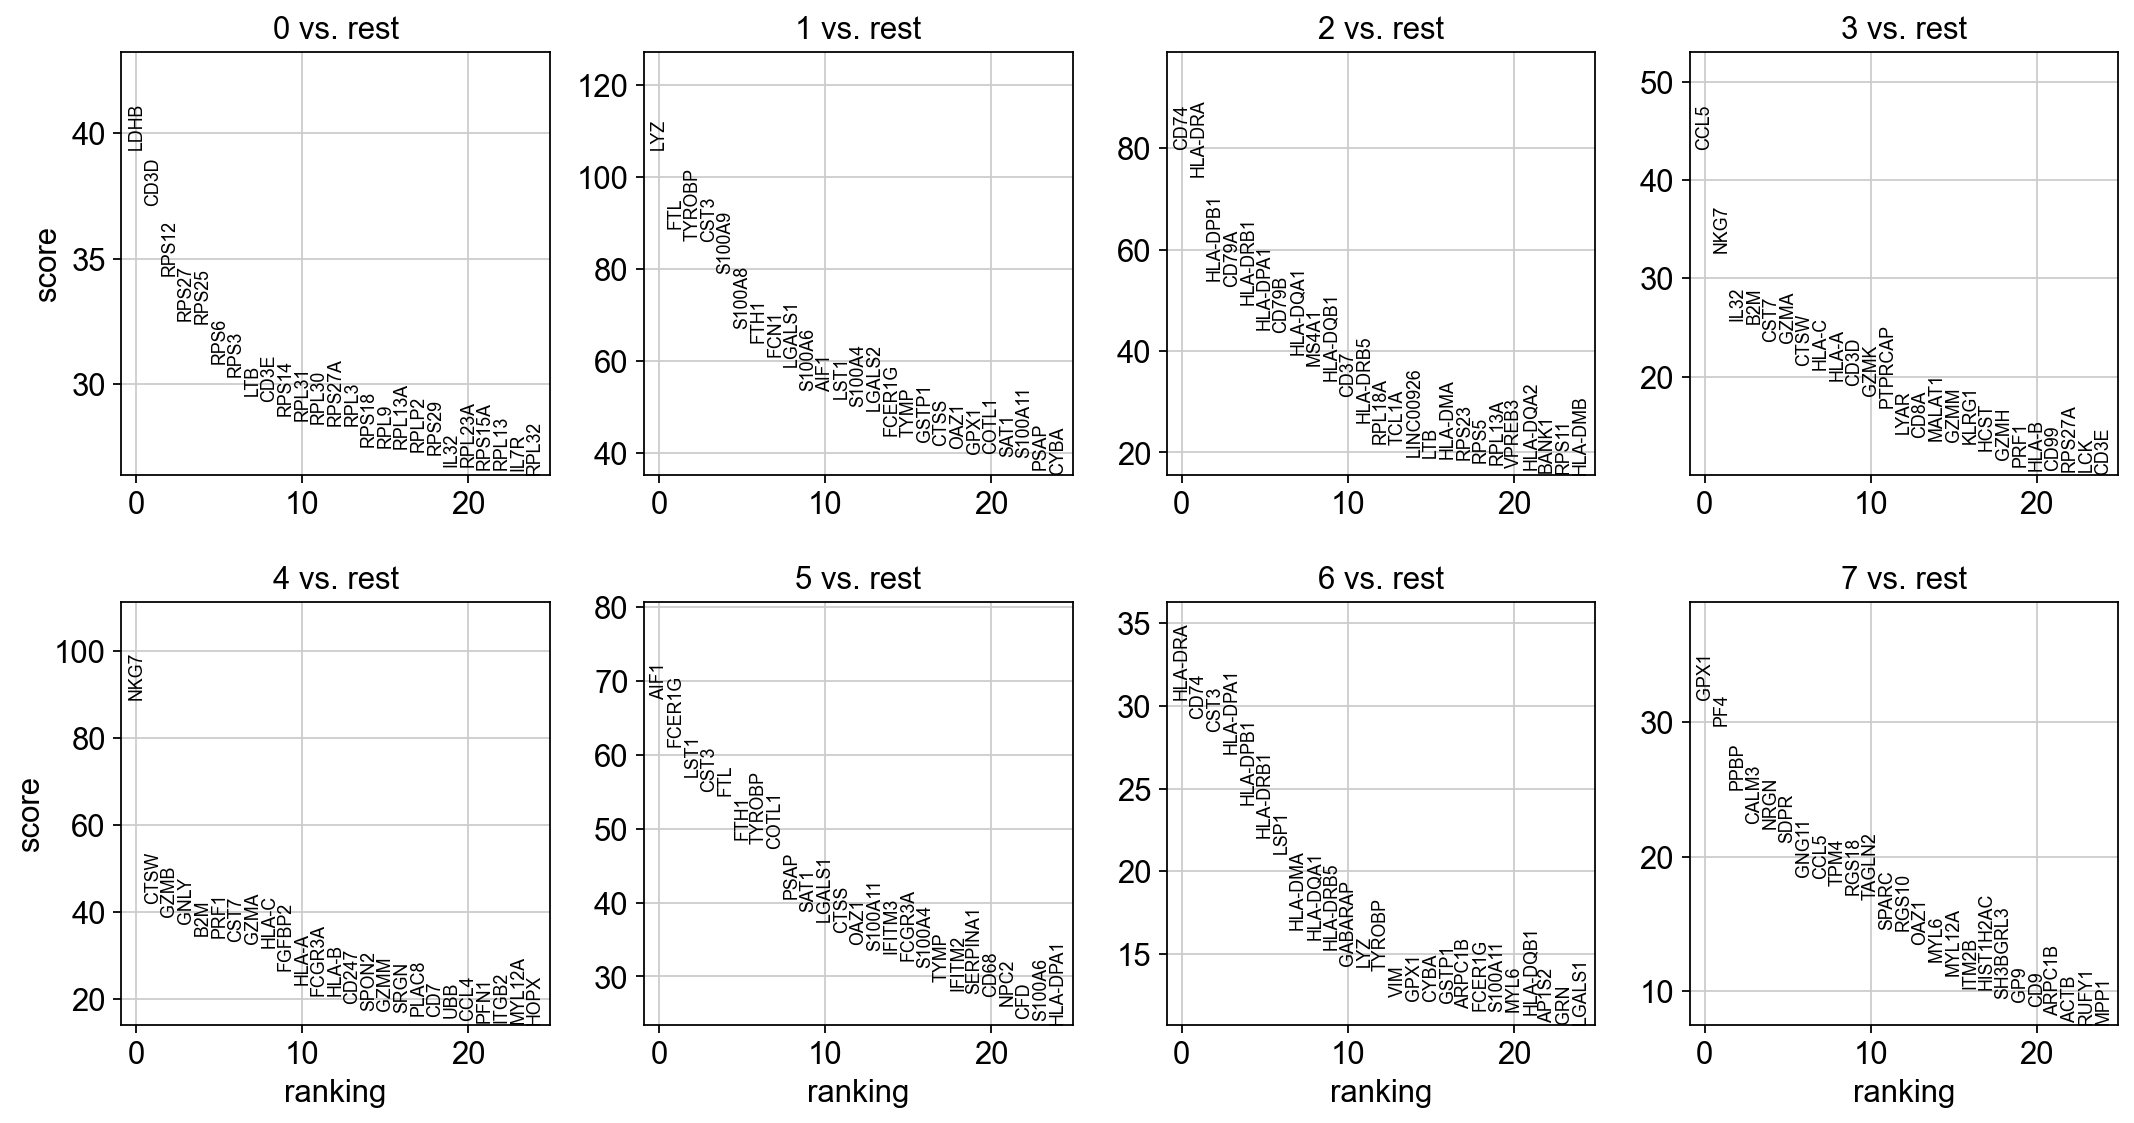

In [41]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [42]:
sc.settings.verbosity = 2  # reduce the verbosity

The result of a Wilcoxon rank-sum (Mann-Whitney-U) test is very similar. We recommend using the latter in publications, see e.g., Sonison & Robinson (2018). You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 and, for python, the recent diffxpy.

ranking genes
    finished (0:00:01)


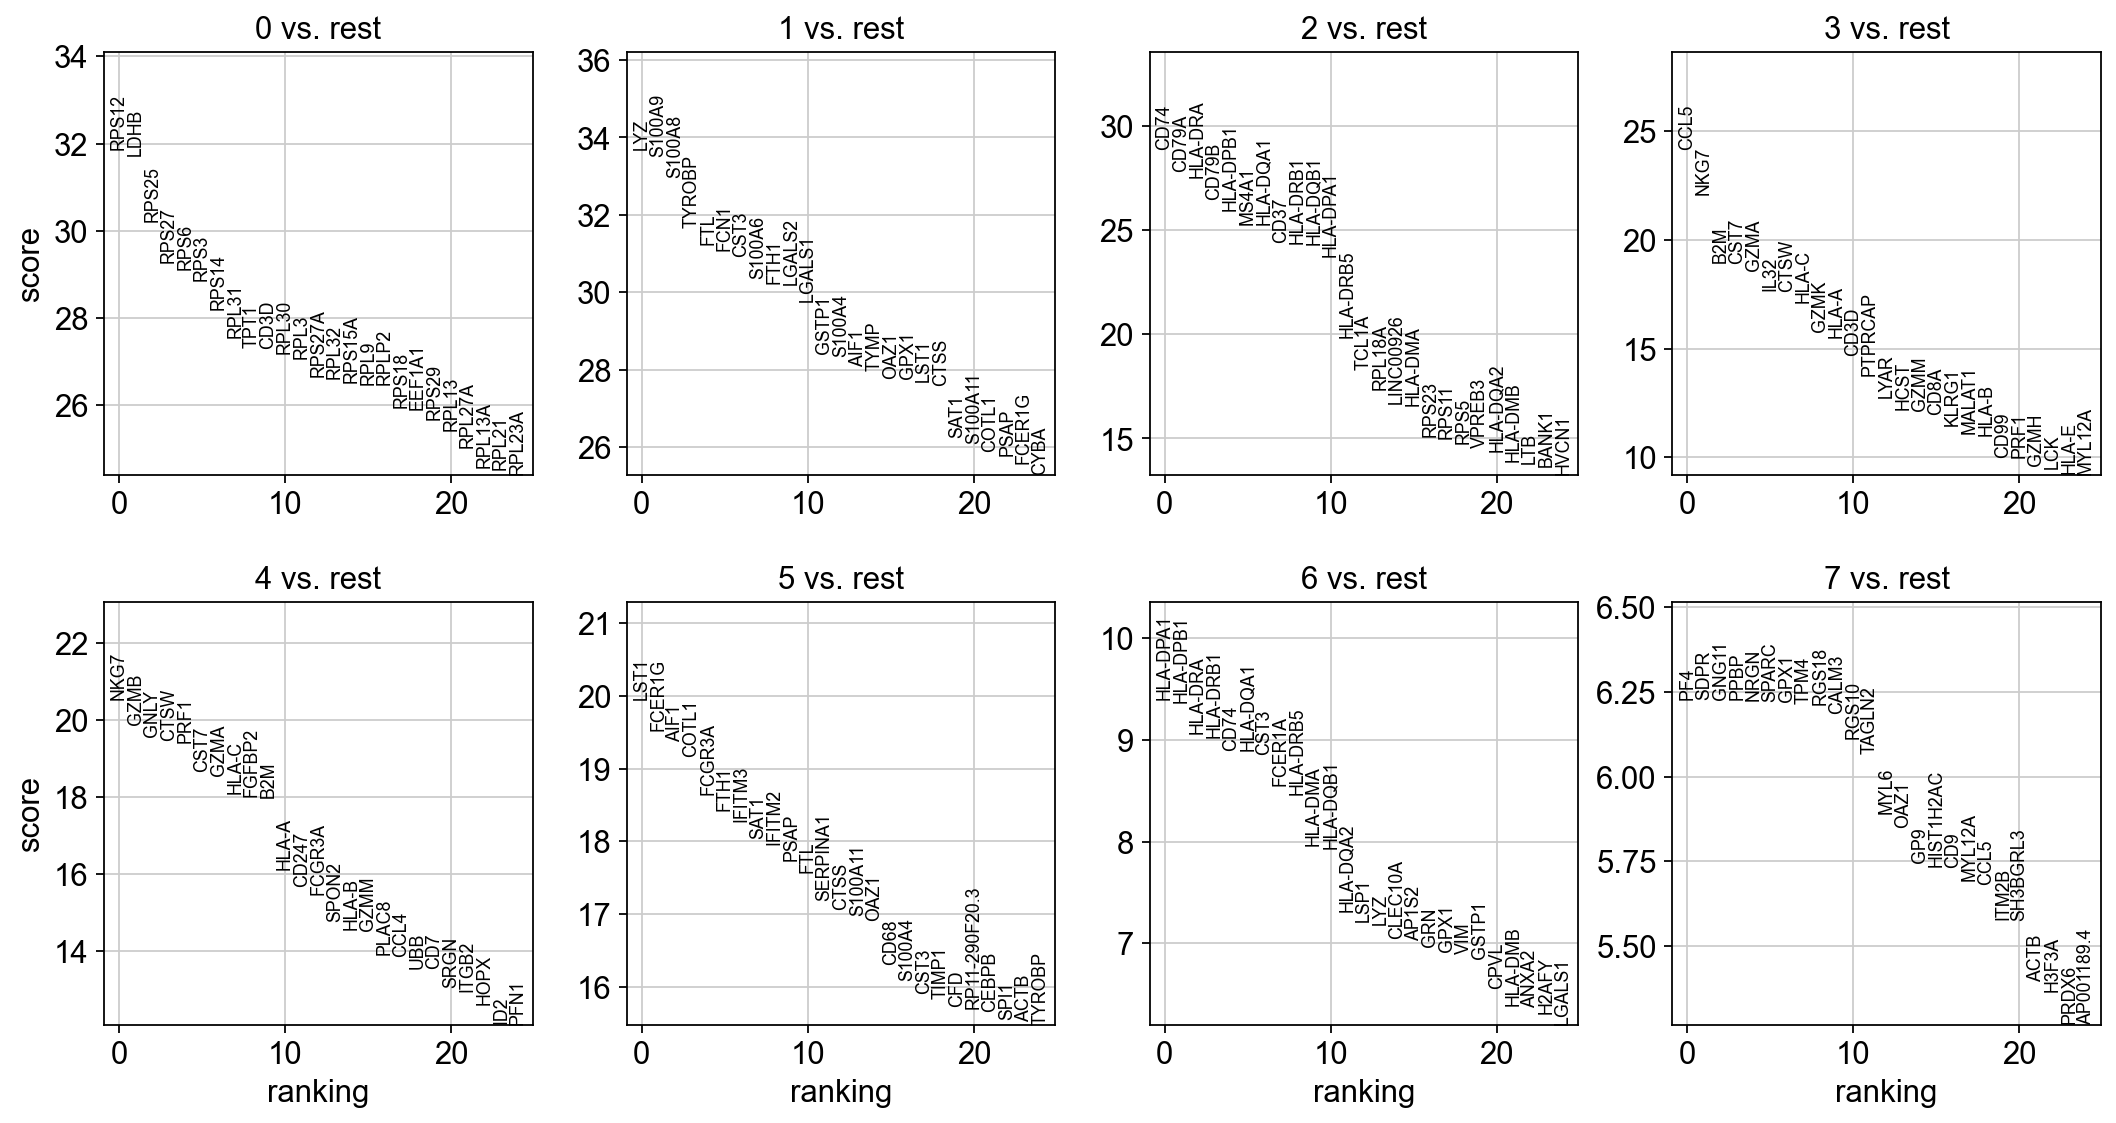

In [43]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [44]:
adata.write(results_file)
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

As an alternative, let us rank genes using logistic regression. For instance, this has been suggested by Natranos et al. (2018). The essential difference is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate. Clark et al. (2014) has more details.

In [45]:
if 0: # That part falls down: 
    sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
    sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Louvain Group	Markers	Cell Type
--------------------------------
0	IL7R	CD4 T cells
1	CD14, LYZ	CD14+ Monocytes
2	MS4A1	B cells
3	CD8A	CD8 T cells
4	GNLY, NKG7	NK cells
5	FCGR3A, MS4A7	FCGR3A+ Monocytes
6	FCER1A, CST3	Dendritic Cells
7	PPBP	Megakaryocytes

In [46]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',  
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [47]:
# Reload the object that has been save with the Wilcoxon Rank-Sum test result.
adata = sc.read(results_file)

In [48]:
# Show the 10 top ranked genes per cluster 0, 1, ..., 7 in a dataframe.
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7
0,RPS12,LYZ,CD74,CCL5,NKG7,LST1,HLA-DPA1,PF4
1,LDHB,S100A9,CD79A,NKG7,GZMB,FCER1G,HLA-DPB1,SDPR
2,RPS25,S100A8,HLA-DRA,B2M,GNLY,AIF1,HLA-DRA,GNG11
3,RPS27,TYROBP,CD79B,CST7,CTSW,COTL1,HLA-DRB1,PPBP
4,RPS6,FTL,HLA-DPB1,GZMA,PRF1,FCGR3A,CD74,NRGN


In [49]:
# Get a table with the scores and groups.
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p
0,RPS12,7.767511e-223,LYZ,7.634876e-249,CD74,2.487145e-183,CCL5,4.572920e-129,NKG7,1.006113e-93,LST1,1.323537e-88,HLA-DPA1,5.422417e-21,PF4,4.722886e-10
1,LDHB,5.617660e-221,S100A9,4.626358e-246,CD79A,1.679730e-170,NKG7,2.719977e-108,GZMB,5.598162e-88,FCER1G,6.259712e-85,HLA-DPB1,7.591860e-21,SDPR,4.733899e-10
2,RPS25,1.382534e-200,S100A8,1.622835e-238,HLA-DRA,6.935111e-167,B2M,3.961151e-80,GNLY,2.214727e-85,AIF1,1.347403e-83,HLA-DRA,1.306768e-19,GNG11,4.733899e-10
3,RPS27,1.702121e-188,TYROBP,2.960765e-220,CD79B,2.569135e-154,CST7,8.995887e-80,CTSW,2.404718e-84,COTL1,5.974694e-82,HLA-DRB1,1.865104e-19,PPBP,4.744938e-10
4,RPS6,2.045168e-186,FTL,2.479195e-214,HLA-DPB1,3.577195e-148,GZMA,2.816469e-77,PRF1,5.451777e-84,FCGR3A,1.392377e-77,CD74,5.853161e-19,NRGN,4.800511e-10


ranking genes
    finished (0:00:00)


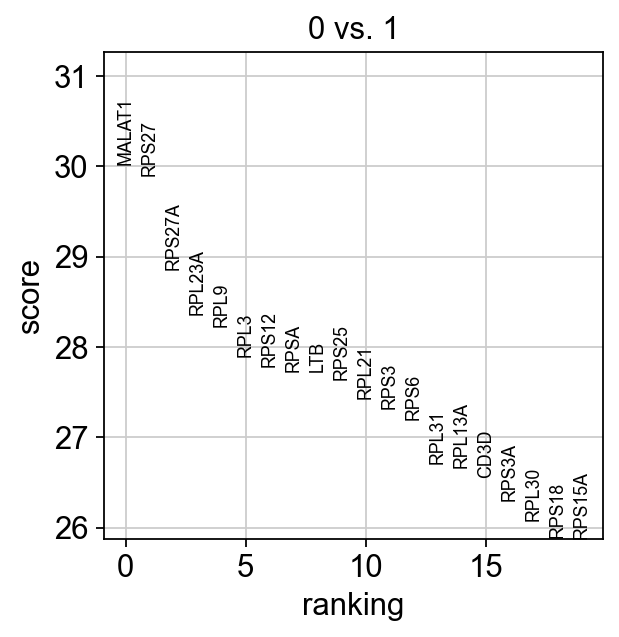

In [50]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

/home/user/BioinformaticTutorials/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/__init__.py:1314: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


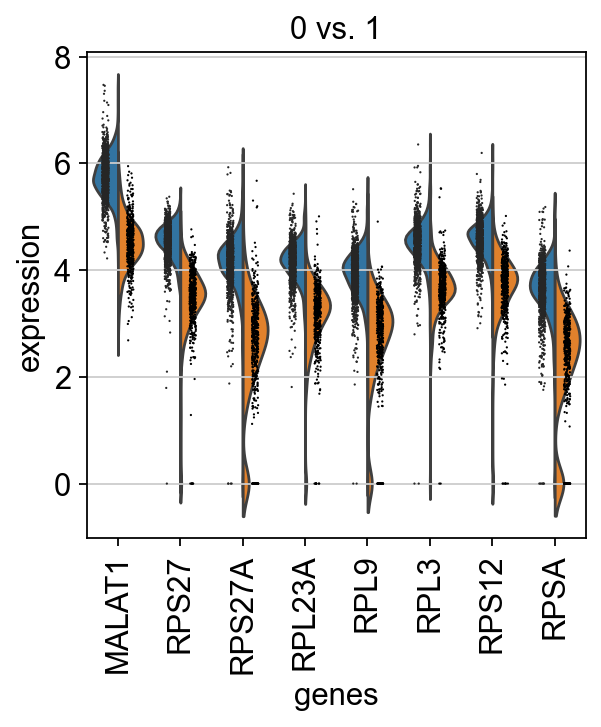

In [51]:
# If we want a more detailed view for a certain group, use sc.pl.rank_genes_groups_violin.
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)


In [52]:
# Reload the object with the computed differential expression (i.e. DE via a comparison with the rest of the groups):


adata = sc.read(results_file)

/home/user/BioinformaticTutorials/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/__init__.py:1314: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


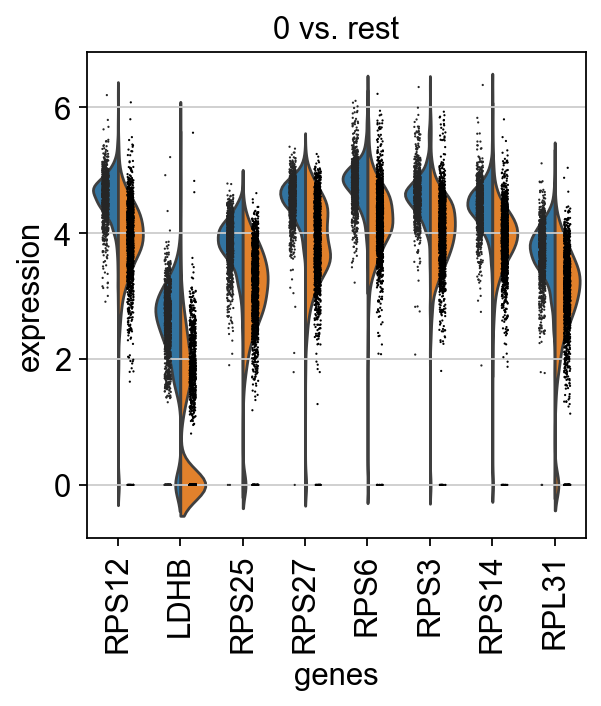

In [53]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

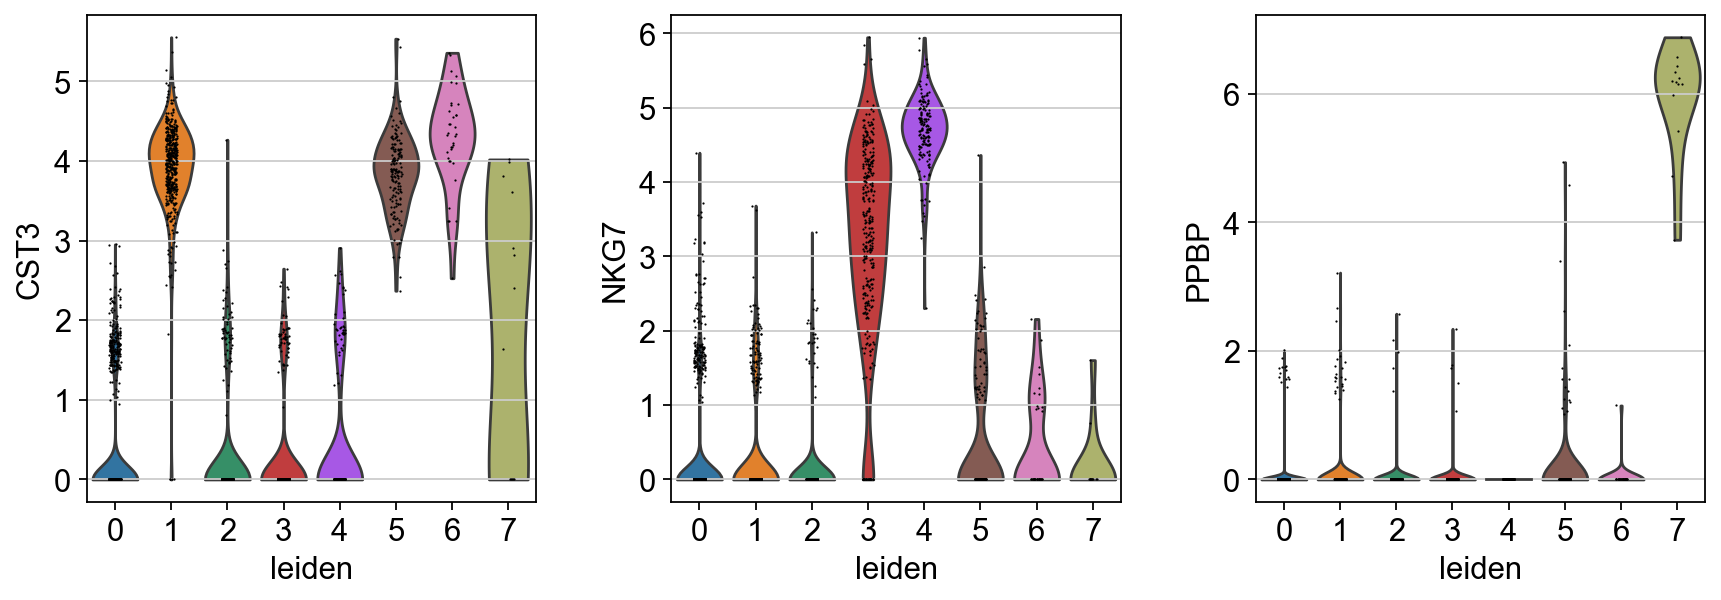

In [54]:

sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

In [55]:
print(adata.obs['leiden'].nunique() )
adata.obs['leiden'].value_counts() 

8


leiden
0    1142
1     478
2     341
3     311
4     159
5     158
6      36
7      13
Name: count, dtype: int64

In [56]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T', 
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
print(len(new_cluster_names))
if 0: # get the different number of clusters then in tutorial

    adata.rename_categories('leiden', new_cluster_names)

8


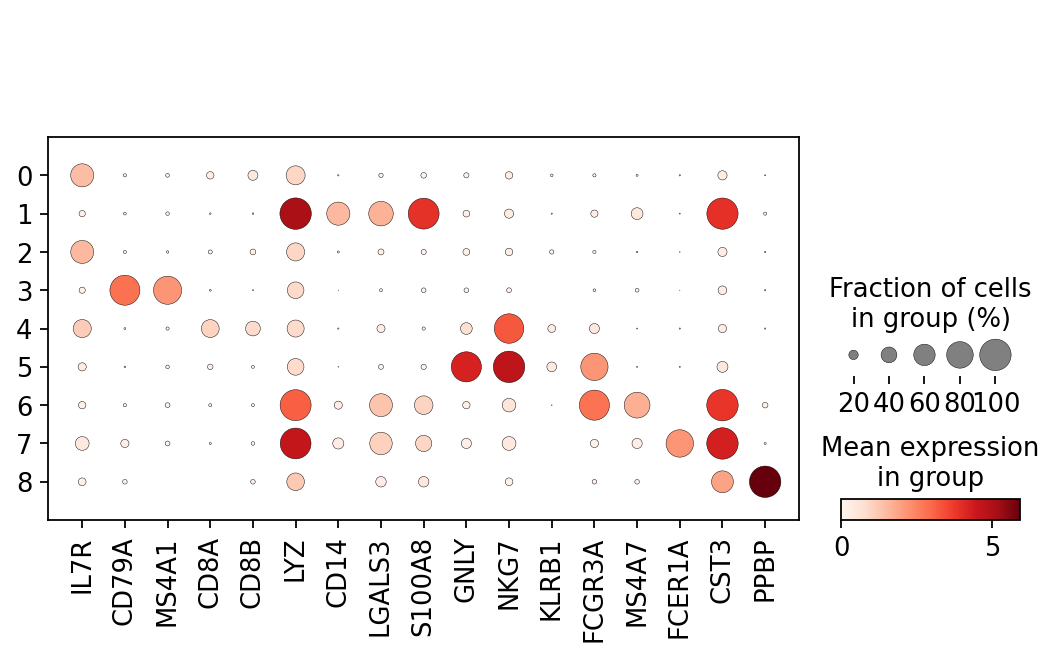

In [54]:
# Now that we annotated the cell types, let us visualize the marker genes.

sc.pl.dotplot(adata, marker_genes, groupby='leiden');


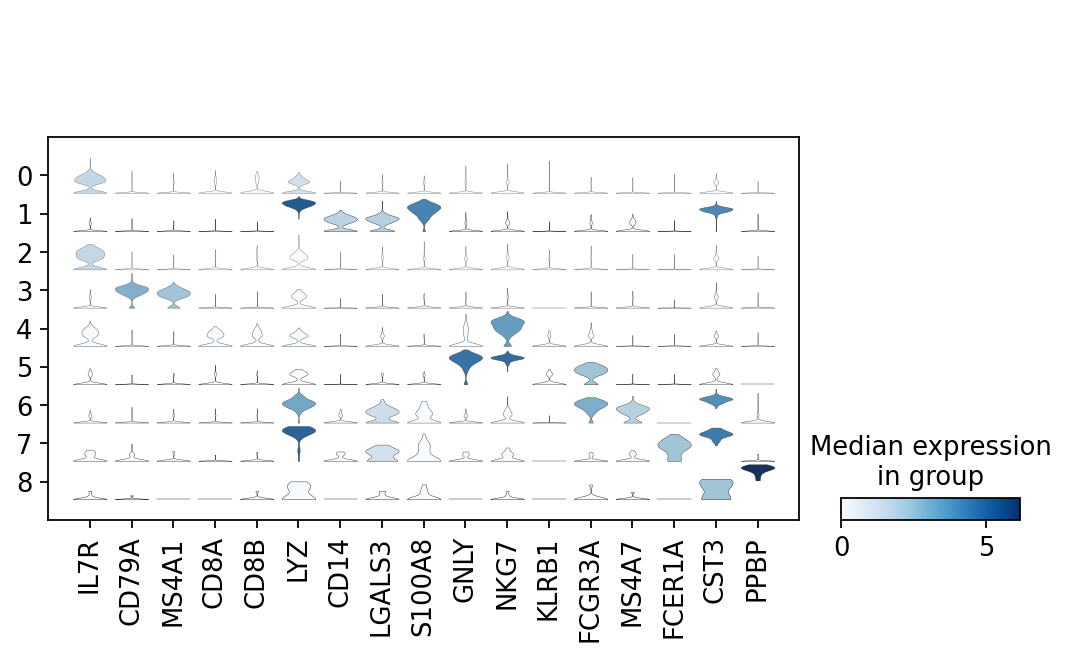

In [55]:
# There is also a very compact violin plot.
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90);

In [56]:
# During the course of this analysis, the AnnData accumlated the following annotations.
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [57]:
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading

Get a rough overview of the file using h5ls, which has many options - for more details see here. The file format might still be subject to further optimization in the future. All reading functions will remain backwards-compatible, though.

If you want to share this file with people who merely want to use it for visualization, a simple way to reduce the file size is by removing the dense scaled and corrected data matrix. The file still contains the raw data used in the visualizations in adata.raw.


In [58]:

adata.raw.to_adata().write('pbmc3k_withoutX.h5ad')

If you want to export to "csv", you have the following options:

In [59]:
# Export single fields of the annotation of observations
# adata.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata.write_csvs(results_file[:-5], )